## Exercise

### 1 .Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
- For consistency, the dataset should have `1000 samples` and a `random_state=42`.
- Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X_moon, y_moon = make_moons(
    n_samples = 1000,
    noise = 0.3,
    random_state = 42
)

X_moon[:10], y_moon[:10]

(array([[-0.17186341,  0.59624885],
        [ 1.25328273, -0.26541353],
        [ 0.72322405,  0.2319425 ],
        [-0.06519764, -0.65519443],
        [-0.79949325,  0.55293543],
        [ 0.71131439,  0.07365753],
        [ 0.26252452, -0.17853072],
        [-0.17500737,  0.5947448 ],
        [ 1.54052117, -0.36735281],
        [ 0.81833812,  1.06585092]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [3]:
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.LongTensor)

X_moon, y_moon[:10]

(tensor([[-0.1719,  0.5962],
         [ 1.2533, -0.2654],
         [ 0.7232,  0.2319],
         ...,
         [ 1.7710, -0.5094],
         [-1.0618,  0.0068],
         [ 0.7612,  0.6520]]),
 tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

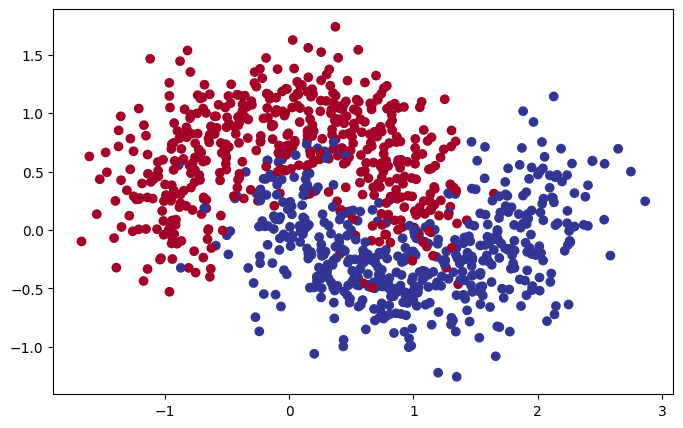

In [4]:
# Plot data
plt.figure(figsize=(8, 5))
plt.scatter(X_moon[:,0],
            X_moon[:,1],
            c = y_moon,
            cmap = plt.cm.RdYlBu);

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_moon,
                                                    y_moon,
                                                    test_size = 0.2,
                                                    random_state = 42)

### 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
- Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [6]:
print(f'Input_features: {X_moon.shape}')

print(f'Unique output classes: {torch.unique(y_moon)}')
print(f'Output_features: {torch.unique(y_moon).shape}')

Input_features: torch.Size([1000, 2])
Unique output classes: tensor([0, 1])
Output_features: torch.Size([2])


In [7]:
class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.RReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Dropout(0.2),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.RReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features),

    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model = MoonModel(input_features = 2,
                  output_features = 2,
                  hidden_units = 64).to(device)

model

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): RReLU(lower=0.125, upper=0.3333333333333333)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
)

In [8]:
next(model.parameters()).device

device(type='cuda', index=0)

In [9]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

### 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
- To measure model accuray, you can create your own accuracy function or use the accuracy function in `TorchMetrics`.
- Train the model for long enough for it to reach over 96% accuracy.
- The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [11]:
torch.manual_seed(42)

epochs = 100

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

# Placing data on CUDA
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Train
for epoch in range(epochs):
  model.train()
  y_logits = model(X_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_preds)

  if epoch % 10 == 0 or epoch == epochs - 1:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    train_acc_values.append(acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch} ---- Train Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 ---- Train Loss: 0.6958 | Acc: 50.00% | Test Loss: 0.5936 | Test Accuracy: 70.00
Epoch: 10 ---- Train Loss: 0.3303 | Acc: 86.12% | Test Loss: 0.3252 | Test Accuracy: 84.00
Epoch: 20 ---- Train Loss: 0.2960 | Acc: 87.12% | Test Loss: 0.2824 | Test Accuracy: 86.00
Epoch: 30 ---- Train Loss: 0.2539 | Acc: 89.75% | Test Loss: 0.2336 | Test Accuracy: 89.00
Epoch: 40 ---- Train Loss: 0.2182 | Acc: 91.25% | Test Loss: 0.1716 | Test Accuracy: 92.50
Epoch: 50 ---- Train Loss: 0.2065 | Acc: 91.50% | Test Loss: 0.1722 | Test Accuracy: 93.00
Epoch: 60 ---- Train Loss: 0.2056 | Acc: 91.62% | Test Loss: 0.1713 | Test Accuracy: 93.50
Epoch: 70 ---- Train Loss: 0.2042 | Acc: 91.62% | Test Loss: 0.1671 | Test Accuracy: 93.00
Epoch: 80 ---- Train Loss: 0.2018 | Acc: 91.38% | Test Loss: 0.1702 | Test Accuracy: 94.00
Epoch: 90 ---- Train Loss: 0.2019 | Acc: 91.62% | Test Loss: 0.1676 | Test Accuracy: 94.00
Epoch: 99 ---- Train Loss: 0.2016 | Acc: 91.62% | Test Loss: 0.1691 | Test Accuracy: 94.00


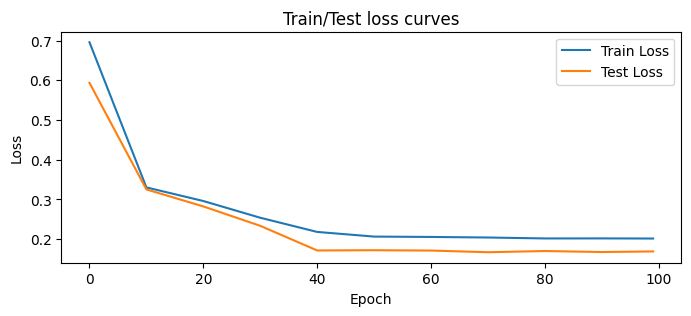

In [12]:
# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

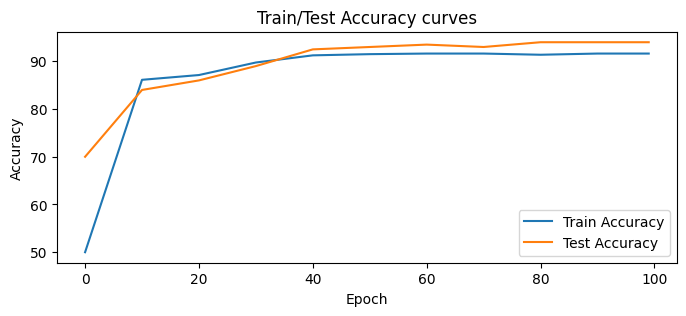

In [13]:
# Plot accuracy curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(train_acc_values).numpy()), label="Train Accuracy")
plt.plot(epoch_count, np.array(torch.tensor(test_acc_values).numpy()), label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

### 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [14]:
torch.manual_seed(42)
# print(X_test.device)
model.eval()
with torch.inference_mode():
  y_logits = model(X_test)

y_logits[:10]

tensor([[-1.3643e+00,  2.1675e+00],
        [-6.6014e-02,  4.0421e-01],
        [-1.5320e+00,  2.4448e+00],
        [ 1.9727e+00, -2.0606e+00],
        [-2.6723e+00,  4.0018e+00],
        [-4.5084e+00,  6.1497e+00],
        [-2.6928e-03,  4.1379e-01],
        [ 4.0656e-01, -4.4908e-02],
        [-3.8415e+00,  5.6819e+00],
        [ 9.4236e-01, -9.8369e-01]], device='cuda:0')

In [15]:
# Transform logits -> Prediction probbailities
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10]

tensor([[2.8420e-02, 9.7158e-01],
        [3.8456e-01, 6.1544e-01],
        [1.8400e-02, 9.8160e-01],
        [9.8259e-01, 1.7407e-02],
        [1.2615e-03, 9.9874e-01],
        [2.3509e-05, 9.9998e-01],
        [3.9736e-01, 6.0264e-01],
        [6.1099e-01, 3.8901e-01],
        [7.3112e-05, 9.9993e-01],
        [8.7281e-01, 1.2719e-01]], device='cuda:0')

In [16]:
# Prediction probabilities -> Pred labels
y_preds = torch.argmax(y_pred_probs, dim = 1)
y_preds[:20], y_test[:20]

(tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
        device='cuda:0'),
 tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0],
        device='cuda:0'))

In [17]:
import requests
from pathlib import Path

# Download helper function from opensource scripts files
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Downloading helper_function.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
  print('Download complete')

helper_functions.py already exists, skipping download


In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)